# Глубокий кросс-энтропийный метод

#### Дедлайн (жёсткий) задания: 17 марта, 23:59 UTC+3

#### При сдаче задания нужно данный файл, файлы logger.py, model.py, agent_wrapper.py, а также папку с логами и папку с видео поместить в архив, сохраняя относительные пути, и послать архив в систему сдачи.

### <span style="color: red"> Если работа была списана и/или сделана LLM, то за работу ставится 0 баллов </span>. 

В данной работе будет рассмотрено обобщение кросс-энтропийного метода на случай параметризации агента с помощью нейросети. Перед вами будет поставлена задача обучить многослойную нейронную сеть для решения простых игр в непрерывных пространствах состояний.

# Работа выполнена: ФИО, номер группы.

In [1]:
import gymnasium as gym
import numpy as np
from pathlib import Path
import pickle as pkl
import pandas as pd
from time import time
from IPython.display import clear_output
from collections import deque
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.)

import torch
import warnings
import logger

In [2]:
import importlib
import model
import agent_wrapper

importlib.reload(model)
importlib.reload(agent_wrapper)

from model import MLPClassifireModel, MLPRegressorModel, MLPBaseModel
from agent_wrapper import show_progress, GYMAgentWrapper

In [24]:
# Для корректной работы ноутбука может понадобиться исполнение следующих команд:
# (инструкция для UNIX-подобных систем):
# !apt-get install -y xvfb x11-utils ffmpeg libav-tools python-opengl swig
# !pip install --upgrade piglet pyvirtualdisplay joblib box2d-py gymnasium
# (команда для MacOS системы):
# !brew install XQuartz swig # для использования xvfb в MacOS сервере (не опробовано)

Для визуализации среды на headless-сервере с UNIX-подобной ОС (например, Google Colab) раскомментируйте следующую ячейку:

In [17]:
# from pyvirtualdisplay import Display # для визуализации на UNIX-подобном сервере


# virtual_display = Display(visible=0, size=(1920, 1080))
# virtual_display.start()

Скрыть предупреждения: эстетическая опция, можно не выполнять ячейку ниже:

In [3]:
warnings.filterwarnings("ignore")

Инициализация среды:

размерность вектора состояний dim = 6
размерность вектора действий dim = 3


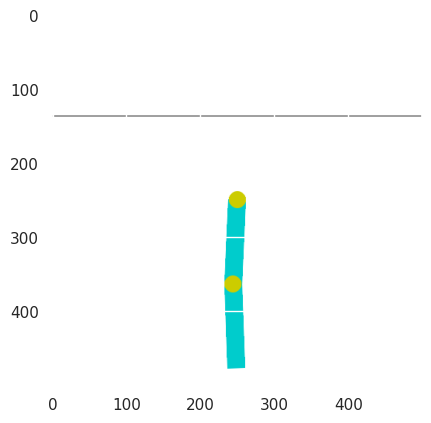

In [4]:
# если есть вывод "<classname> has no attribute .env", удалите .env или обновите gym
arcrobot_env = gym.make("Acrobot-v1", render_mode="rgb_array").env

arcrobot_env.reset()
n_actions = arcrobot_env.action_space.n
state_dim = arcrobot_env.observation_space.shape[0]

plt.imshow(arcrobot_env.render())
print("размерность вектора состояний dim =", state_dim)
print("размерность вектора действий dim =", n_actions)

arcrobot_env.close()

# Нейросетевая политика,  <span style="color: green"> основная задача (10 баллов) </span>. 

Для текущей задачи будет использована написанная Вами нейросеть на подобие __[Scikit-learn MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__.


Для решения задачи понадобится:
* Реализовать недостающие строки в файле `model`, смотри строки `35` (метод `__init__` у класса `MLPBaseModel`), `249` (метод `partial_fit` у класса `MLPClassifireModel`)
* Реализовать отрисовку средних наград и порогов наград на одном графике, распределение наград по значением и линия заданного перцентиля на другом графике. Смотри в файле `agent_wrapper`, строка `41` (функция show_progress).
* Реализовать отбор лучших сессий и действий, для обучения на них модели. Смотри в файле `agent_wrapper`, строка `125` (staticmethod `select_best_session` у класса `GYMAgentWrapper`).

Целью основной части работы является с помощью глубокого кросс-энтропийного метода обучить агента действовать в среде [Arcrobot-v1](https://gymnasium.farama.org/environments/classic_control/acrobot/). Хорошим результатом считается достижение награды -75 или выше.

Архитектуру сети (количество слоев, количество нейронов в каждом слое, оптимизатор) можете выбрать по своему усмотрению.

### Шаги кросс-энтропийного метода
Общая схема кросс-энтропийного метода (CEM) приведена на странице 35 (параграф 2.2.4.) учебного [пособия](https://arxiv.org/pdf/2201.09746.pdf).

Глубокий CEM использует точно такую же стратегию, что и обычный CEM.

Главное отличие состоит в том, что теперь каждое наблюдение не число, а `float32` вектор. Этот пример мы и будем рассматривать.

In [50]:
# инициализация агента и среды обучения

arcrobot_env = gym.make("Acrobot-v1", render_mode="rgb_array").env
model = MLPBaseModel(input_dim=6, output_dim=3, inner_dims=[32, 64, 32, 32], activation_func=torch.nn.Tanh())
acrobot = GYMAgentWrapper(arcrobot_env, MLPClassifireModel(model, lr=1e-2), show_progress) # можно менять архитектуру нейронной сети и гиперпараметры обучения
acrobot_logger = logger.get_logger('arcrobot_v_1', './logs')
acrobot.set_sesion_params(max_step=1000, test=False, epsilon=1e-2)
# acrobot.agent.set_normalization_params(acrobot.gym_env.observation_space)
acrobot.set_train_agent_params(train_steps=25, session_quantity=100, percentile=85, goal_score=-75, history_length = 1, verbose=True) # можно менять гиперпраметры кросс-энтропийного метода, goal_score не трогать

# пример инициализации агента и среды обучения с моделью не по умолчанию:
# MLPBaseModel(input_dim=6, output_dim=3, inner_dims=[2,3,1,4], activation_func=torch.nn.Tanh())
# arcrobot = GYMAgentWrapper(gym_env, MLPClassifireModel(base_model, torch.optim.SGD), show_progress)
# также можно добавить нормализацию входных параметров с помощью arcrobot.agent.set_normalization_params(arcrobot.gym_env.observation_space)

# Цикл обучения
Генерация эпизодов, выбор пресентиля лучших и обучение на них.

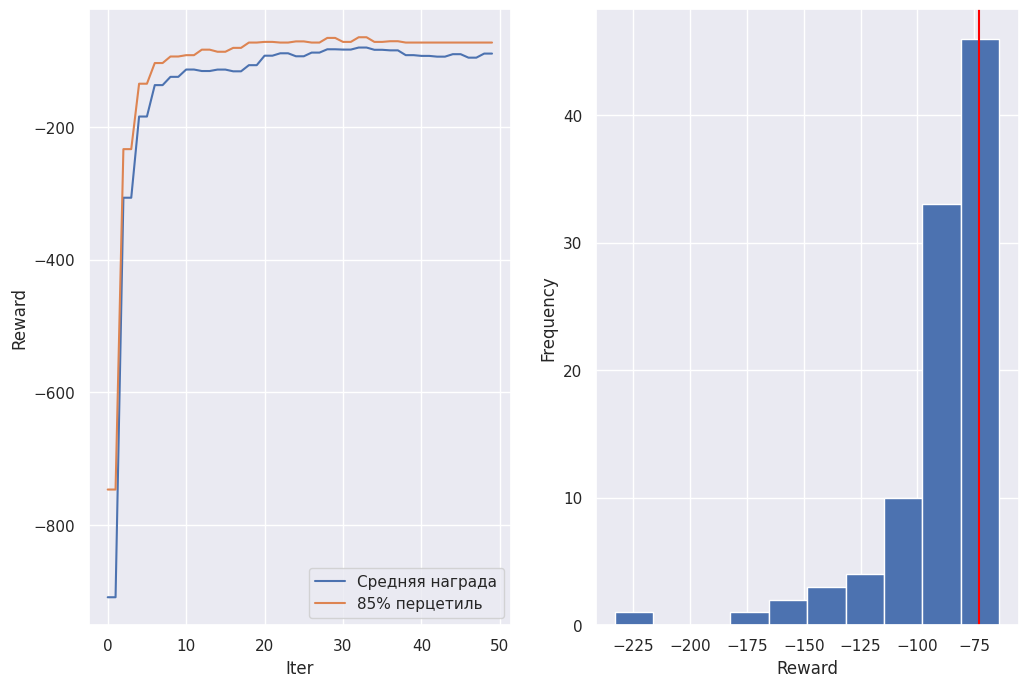

средняя награда = -89.610, порог=-73.000


In [51]:
acrobot_result = acrobot.train_agent()

logger.log_func(acrobot_logger, acrobot_result)


In [62]:
acrobot.agent.set_learning_rate(3e-3)
acrobot.set_sesion_params(test=False, epsilon=0)
acrobot.set_train_agent_params(train_steps=150, session_quantity=10, percentile=70, goal_score=-75, history_length = 1, verbose=True)

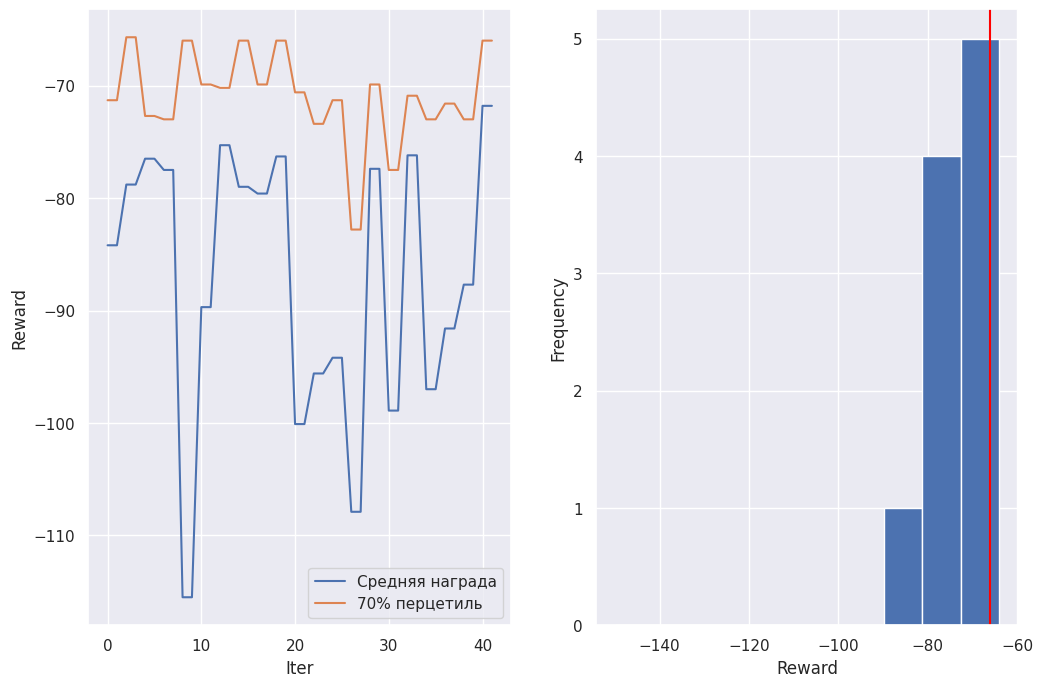

средняя награда = -71.800, порог=-66.000
Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.


In [63]:
acrobot_result = acrobot.train_agent()

logger.log_func(acrobot_logger, acrobot_result)

# Результаты

In [ ]:
'''
Если не работают ячейки ниже, то .record_wideo() надо зменить на

with RecordVideo(
    env=gym.make("env_name", render_mode="rgb_array"),
    video_folder=folder_pth,
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [agent_wrapper._generate_session(env_monitor, agent_wrapper.session_params) for _ in range(5)]

'''

Детерминированная политика:

In [64]:
# сохранение видео
folder_pth = Path("./videos/Arcrobot_V_1/determ_poliсy")
acrobot.set_sesion_params(test=True)
acrobot.record_wideo(folder_pth, 10)

# демонстрация видео
video_paths = sorted([s for s in folder_pth.iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-0.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-1.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-1.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-2.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-2.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-3.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-3.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-4.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-4.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-5.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-5.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-6.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-6.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-7.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-7.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-8.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-8.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-9.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/determ_poliсy/rl-video-episode-9.mp4


Стохастическая политика:

In [65]:
# сохранение видео
folder_pth = Path("./videos/Arcrobot_V_1/stoch_poliсy")
acrobot.set_sesion_params(test=False)
acrobot.record_wideo(folder_pth, 10)

# демонстрация видео
video_paths = sorted([s for s in folder_pth.iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-0.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-0.mp4


Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-1.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-1.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-2.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-2.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-3.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-3.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-4.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-4.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-5.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-5.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-6.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-6.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-7.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-7.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-8.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-8.mp4
Moviepy - Building video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-9.mp4.
Moviepy - Writing video /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/semyon/ML/RL/CrossEntropyMethod/videos/Arcrobot_V_1/stoch_poliсy/rl-video-episode-9.mp4


### Как думаете, какую политику (детерминированную или стохастическую) стоит выбирать с случае 
* обучения агента?
* достижения лучшей награды?
Свою точку зрения объясните.

На этапе обучения используем стохастическую политику, чтобы обеспечивать exploration.

На инференсе обычно будет лучше работать детерминированная политика, т.к. мы будем выбирать самое эффективное действие в текущем состоянии (т.е. то, которое на этапе обучения приводило к наибольшей награде) 

# Дополнительные задание <span style="color: green"> (Всего 10 баллов) </span>

### Глубокий кросс-энтропийный метод

На данный момент у Вас должна быть достаточно хорошая награда в [Acrobot-v1](https://gymnasium.farama.org/environments/classic_control/acrobot/), чтобы считать основное задание выполненным (см. ссылку). Время попробовать что-нибудь посложнее.

### Задания

* __2.1__ Выбрать следующие среды: [MountainCar-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car/) и [LunarLander-v3](https://gymnasium.farama.org/environments/box2d/lunar_lander/). <span style="color: green"> (Всего 2 балла, по 1 за каждую из сред) </span>
  * Для MountainCar, получить среднее вознаграждение __как минимум -150__
  * For LunarLander, получить среднее вознаграждение __как минимум +65__
  * Записать видео для каждой из среды

Рекомендуем обратить внимание на раздел с советами ниже, это важно.

Для данной задачи нужно будет разобраться как использовать другую среду, возможно изменить модель, лосс и оптимизатор с шагом.

* __2.2__ Изучить зависимость скорости обучения агента от гиперпараметров алгоритма в среде [MountainCar-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car/). Постараться продемонстрировать возможность ускорения обучения хотя бы в два раза при грамотном подборе гиперпараметров. <span style="color: green"> (Всего 3 балла, по 1 за пункт) </span>
  * Очевидное улучшение: использовать [joblib](https://joblib.readthedocs.io/en/stable/) или multiprocessing (смотри `parallel` и `n_workers` поля класса `train_agent_params` в файле `agent_wrapper`)
  * Попробовать переиспользовать сэмплы из 3-5 последних итераций при вычислении порога и при обучении (смотри `history_length` поле в файле `agent_wrapper`)
  * Поэкспериментировать с количеством итераций обучения и шагом метода обучения (learning rate) нейронной сети 

Для решения этого пункта нужно будет реализовать код в файле `agent_wrapper` на строке `343` (метод `train_agent` класса `GYMAgentWrapper`).

* __2.3__ Обучить агента в среде с непрерывным пространством действий с помощью `MLPRegressor` на подобие ([ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)). <span style="color: green"> (Всего 5 баллов, по 1.5 за каждую из сред, 0.5 за реализацию кода) </span>
  * Начните с [Pendulum-v1](https://gymnasium.farama.org/environments/classic_control/pendulum/), попробуйте получить среднее вознаграждение **как минимум -300**.
  * Поскольку Ваш агент оценивает "среднее" действие, полезно добавить небольшой шум для исследования среды.
  * Обучить агента в [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) и в [LunarLanderContinuous-v3](https://gymnasium.farama.org/environments/box2d/lunar_lander/). За достижение награды ниже порогового значения будет начислено меньше баллов. Помните, что дискретные и непрерывные среды могут отличаться не только в пространстве действий. Требования на среднее вознаграждение: **MountainCarContinuous +70** и **LunarLanderContinuous +100**.

Для решения этого пункта нужно будет реализовать код в файле `model` на строке `182` (метод `partial_fit` класса `MLPRegressorModel`). Это не должно вызвать у вас проблем, после написания подобного кода для задачи классификации.

* __При сдаче задания требуется перечислить в данном файле, что было сделано и чего добились__
  
### Советы
* Страница Gymnasium: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [MountainCarContinuous](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/).
* Эпизоды в MountainCar могут длиться более 10k+ шагов. Убедитесь, что параметр `max_step` в `set_sesion_params` не меньше 10k.
 * Также может быть хорошей идеей строго отбирать награды через ">", а не ">=" (strictly_select_elites). Если 90% Ваших эпизодов имеют награду -10k и 20% лучше, тода если Вы используйте перцентиль 20% как порог, R >= порог __не может отклонить неуспешные эпизоды__, в то время как R > справляется с этим корректно.
* _проблема сред gymnasium_: некоторые версии gymnasium ограничивают эпизод 200 шагами. Это ограничивает возможности CEM в обучении в большинстве случаев. Убедитесь, что Ваш агент способен симулировать эпизоды с заданным __t_max__, и если нет, то попробуйте `env = gym.make("MountainCar-v0").env` или в ином случае избавьтесь от TimeLimit wrapper.
* Если Вы пользуетесь старой _swig_ библиотекой для LunarLander-v3, у Вас может возникнуть ошибка. Детали по [ссылке](https://github.com/openai/gym/issues/100) с решением проблемы.
* Если CEM не будет обучаться, то построение диаграмм распределения награды и запись видео эпизодов могут помочь: они Вас могут натолкнуть на идею исправления.
* 20-нейронной сети может не хватить, не стесняйтесь экспериментировать.

Ячейка с кодом ниже может оказаться полезной:

### <span style="color: green"> Дополнительное задание 2.1 (2 балла, по 1 за каждую из сред) </span>
Требуется: 

Выбрать следующие среды: [MountainCar-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car/) и [LunarLander-v3](https://gymnasium.farama.org/environments/box2d/lunar_lander/).
  * Для MountainCar, получить среднее вознаграждение __как минимум -150__
  * For LunarLander, получить среднее вознаграждение __как минимум +50__
  * Записать видео для каждой из сред

Рекомендуем обратить внимание на раздел с советами ниже, это важно.

Для данной задачи нужно будет разобраться как использовать другую среду, возможно изменить модель, лосс и оптимизатор с шагом.

### Обучение в MountainCar-v0

In [ ]:
# инициализация агента и среды обучения
mountin_car_env = gym.make("MountainCar-v0", render_mode="rgb_array").env
n_actions = mountin_car_env.action_space.n
state_dim = mountin_car_env.observation_space.shape[0]

mountin_car = GYMAgentWrapper(mountin_car_env, MLPClassifireModel(model=MLPBaseModel(input_dim=int(state_dim), output_dim=int(n_actions), inner_dims=[4, 8, 24, 6])), show_progress) # можно менять архитектуру нейронной сети и гиперпараметры обучения
mountin_car_logger = logger.get_logger('mountaincar-v0', './logs')
mountin_car.set_sesion_params(max_step=15000, test=False, epsilon=0)
mountin_car.set_train_agent_params(train_steps=100, session_quantity=100, percentile=90, goal_score=-150, history_length = 1, verbose=True, strict=True) # можно менять гиперпраметры кросс-энтропийного метода, goal_score не трогать

mountin_car_result = mountin_car.train_agent()

logger.log_func(mountin_car_logger, mountin_car_result)

In [ ]:
# детерминированная политика
# сохранение видео
folder_pth = Path("./videos/MountainCar-v0/determ_poliсy")
mountin_car.set_sesion_params(test=True)
mountin_car.record_wideo(folder_pth, 10)

# демонстрация видео
video_paths = sorted([s for s in folder_pth.iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

In [ ]:
# стохастическая политика
# сохранение видео
folder_pth = Path("./videos/MountainCar-v0/stoch_poliсy")
mountin_car.set_sesion_params(test=False)
mountin_car.record_wideo(folder_pth, 10)

# демонстрация видео
video_paths = sorted([s for s in folder_pth.iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

### Обучение в LunarLander-v3

In [ ]:
# инициализация агента и среды обучения
lunarlander_env = gym.make("LunarLander-v3", render_mode="rgb_array").env
n_actions = lunarlander_env.action_space.n
state_dim = lunarlander_env.observation_space.shape[0]

lunarlander = GYMAgentWrapper(lunarlander_env, MLPClassifireModel(model=MLPBaseModel(input_dim=state_dim, output_dim=n_actions)), show_progress) # можно менять архитектуру нейронной сети и гиперпараметры обучения
lunarlander_logger = logger.get_logger('lunarlander-v3', './logs')
lunarlander.set_sesion_params(max_step=1000, test=False, epsilon=0)
lunarlander.set_train_agent_params(train_steps=150, session_quantity=100, percentile=90, goal_score=50, history_length = 1, verbose=True, strict=False) # можно менять гиперпраметры кросс-энтропийного метода, goal_score не трогать

lunarlander_result = lunarlander.train_agent()

logger.log_func(lunarlander_logger, lunarlander_result)

In [ ]:
# детерминированная политика
# сохранение видео
folder_pth = Path("./videos/LunarLander-v3/determ_poliсy")
mountin_car.set_sesion_params(test=True)
mountin_car.record_wideo(folder_pth, 10)

# демонстрация видео
video_paths = sorted([s for s in folder_pth.iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

In [ ]:
# стохастическая политика
# сохранение видео
folder_pth = Path("./videos/LunarLander-v3/stoch_poliсy")
mountin_car.set_sesion_params(test=False)
mountin_car.record_wideo(folder_pth, 10)

# демонстрация видео
video_paths = sorted([s for s in folder_pth.iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

### <span style="color: green"> Дополнительное задание 2.2  (Всего 3 балла, по 1 за пункт) </span>
Требуется:

Изучить зависимость скорости обучения агента от гиперпараметров алгоритма в среде [MountainCar-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car/). Постараться продемонстрировать возможность ускорения обучения хотя бы в два раза при грамотном подборе гиперпараметров. 
  * Очевидное улучшение: использовать [joblib](https://joblib.readthedocs.io/en/stable/) или multiprocessing (смотри `parallel` и `n_workers` поля класса `train_agent_params` в файле `agent_wrapper`)
  * Попробовать переиспользовать сэмплы из 3-5 последних итераций при вычислении порога и при обучении (смотри `history_length` поле в файле `agent_wrapper`)
  * Поэкспериментировать с количеством итераций обучения и шагом метода обучения (learning rate) нейронной сети 

Для решения этого пункта нужно будет реализовать код в файле `agent_wrapper` на строке `343` (метод `train_agent` класса `GYMAgentWrapper`).

Сейчас будем много кода, но не стоит пугаться, это все для упрощения Вашей жизни.

Функция для постановки экспериментов, зависящих от набора гиперпараметров:

In [ ]:
example_wrapper = GYMAgentWrapper(your_params) # можно менять архитектуру нейронной сети и гиперпараметры обучения
def training_experiment(n_jobs_list, history_length_list, learning_rate_init_list, n_train_steps_list,
                        n_samples=5, name='MountainCar-v0', n_game_steps=10000, n_sessions=100, percentile=70,
                        goal_score=-150, **params):
    experiment_data = []
    
    for n_jobs in n_jobs_list:
        for history_length in history_length_list:
            for learning_rate_init in learning_rate_init_list:
                params['learning_rate_init'] = learning_rate_init
                for n_train_steps in n_train_steps_list:
                    elapsed_time_list = []
                    log_list = []
                    
                    for i in range(n_samples):
                        print(
                            'Запуск: n_jobs = {}, history_length = {},\n'.format(
                                n_jobs, history_length) +\
                            '                  learning_rate_init = {}, n_train_steps = {};\n'.format(
                                learning_rate_init, n_train_steps) +\
                            'сэмпл {} из {}.'.format(
                                i + 1, n_samples), flush=True)
                        example_wrapper.set_sesion_params(max_step=n_game_steps ,test = False, epsilon=0.01)
                        example_wrapper.set_train_agent_params(train_steps=n_sessions, percentile=percentile, goal_score=goal_score, history_length=history_length, verbose=True, parallel=True, n_workers=n_jobs)
                        example_wrapper.agent.set_learning_rate(learning_rate_init)
                        elapsed_time = time()
                        
                        log = example_wrapper.train_agent()
                        example_wrapper.reset_all_params()
                        
                        elapsed_time_list.append(time() - elapsed_time)
                        
                        log_list.append(log)
                        
                        del log
                        
                    results = {
                               'name': name,
                               'goal_score': goal_score,
                               'n_jobs': n_jobs,
                               'elapsed_time_list': elapsed_time_list,
                               'history_length': history_length,
                               'learning_rate_init': learning_rate_init,
                               'n_train_steps': n_train_steps,
                               'log_list': log_list
                              }
                        
                    experiment_data.append(results)
                    
                    del elapsed_time_list, log_list
    return experiment_data

Функция-помощник для визуализации эффектов от переиспользования сэмплов:

In [ ]:
def plot_history_length_experiment_results(df_data):
    history_length_vals = []
    train_step_vals = []
    reward_vals = []
    mean_threshold_vals = []
    
    for config in df_data:
        for log in config['log_list']:
            mean_rewards, reward_thresholds = zip(*log)
            mean_rewards, reward_thresholds = list(mean_rewards), list(reward_thresholds)
            reward_vals.extend(mean_rewards)
            reward_vals.extend(reward_thresholds)
            train_steps_num = len(mean_rewards)
            train_step_vals.extend(range(train_steps_num))
            train_step_vals.extend(range(train_steps_num))
            history_length_vals.extend([config['history_length']] * train_steps_num * 2)
            mean_threshold_vals.extend(['mean'] * train_steps_num)
            mean_threshold_vals.extend(['threshold'] * train_steps_num)
    
    df = pd.DataFrame({'Переиспользованных шагов': history_length_vals, 'Шаг №': train_step_vals,
                       'Награда': reward_vals, 'Вид награды': mean_threshold_vals})
    last_steps_count = np.sort(df.loc[:, 'Переиспользованных шагов'].unique())
    max_n_colors = last_steps_count.size
    palette = dict(zip(last_steps_count, sns.hls_palette(max_n_colors, l=.45, s=.8)))
    
    sns.set(font_scale=1.35)
    g = sns.relplot(x='Шаг №', y='Награда', hue='Переиспользованных шагов', style='Вид награды', kind='line',
                    data=df, height=8, aspect=1.5, palette=palette)
    g.fig.suptitle('Влияние количества переиспользованных шагов при обучении {}'.format(df_data[0]['name']))
    clear_output(True)
    plt.show()

Функция-помощник для визуализации влияния шага обучения и количества итераций при обучении агента:

In [ ]:
def plot_lrt_experiment_results(df_data):
    learning_rate_vals = []
    max_train_steps_vals = []
    train_step_vals = []
    reward_vals = []
    mean_threshold_vals = []
    
    for config in df_data:
        for log in config['log_list']:
            mean_rewards, reward_thresholds = zip(*log)
            mean_rewards, reward_thresholds = list(mean_rewards), list(reward_thresholds)
            reward_vals.extend(mean_rewards)
            reward_vals.extend(reward_thresholds)
            train_steps_num = len(mean_rewards)
            train_step_vals.extend(range(train_steps_num))
            train_step_vals.extend(range(train_steps_num))
            learning_rate_vals.extend([config['learning_rate_init']] * train_steps_num * 2)
            max_train_steps_vals.extend([config['n_train_steps']] * train_steps_num * 2)
            mean_threshold_vals.extend(['mean'] * train_steps_num)
            mean_threshold_vals.extend(['threshold'] * train_steps_num)
       
    df = pd.DataFrame({'Шаг метода': learning_rate_vals, 'Максимум шагов': max_train_steps_vals,
                       'Шаг №': train_step_vals, 'Награда': reward_vals,
                       'Вид награды': mean_threshold_vals})
    
    lr_vals = np.sort(df.loc[:, 'Шаг метода'].unique())
    max_n_colors = lr_vals.size
    palette = dict(zip(lr_vals, sns.hls_palette(max_n_colors, l=.45, s=.8)))
    
    sns.set(font_scale=1.35)
    g = sns.relplot(x='Шаг №', y='Награда', hue='Шаг метода', style='Вид награды', kind='line',
                    row='Максимум шагов', data=df, height=6, aspect=1.8, palette=palette)
    g.fig.suptitle('Влияние шага метода и количества итераций на {}'.format(df_data[0]['name']),
                   x=0.8, y=1.05)
    leg = g._legend
    for lr, label in zip(lr_vals, leg.texts[1:]):
        label.set_text("{:.4f}".format(lr))
    clear_output(True)
    plt.show()

In [ ]:
#Сетка параметров для проведения экспериментов:
n_jobs_list = < сетка на количество процессов >
history_length_list = < сетка на размер истории >
learning_rate_init_list = < сетка на шаги метода >
n_train_steps_list = < сетка на количество итераций метода >

In [ ]:
#Поиск оптимального количества параллельных легковесных процессов (нитей) на конечной машине:
%%time

n_jobs_experiment_data = < запуск перебора на сетке с помощью training_experiment >

pkl.dump(n_jobs_experiment_data, open('MountainCar-v0_n_jobs_experiment_data.pkl', 'wb'))
clear_output(True)

In [ ]:
#Визуализация результатов эксперимента:

n_jobs_vals = []
elapsed_time_vals = []
elapsed_time_vars = []

for config in n_jobs_experiment_data:
    n_jobs_vals.append(config['n_jobs'])
    elapsed_time_vals.append(np.mean(config['elapsed_time_list']))
    elapsed_time_vars.append(np.std(config['elapsed_time_list']))

df = pd.DataFrame({'Количество нитей': n_jobs_vals, 'Средний ETA, сек.': elapsed_time_vals,
                   'Стандартное отклонение ETA': elapsed_time_vars})

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.35)
plt.title('Производительность 5 итераций обучения на {}'.format(n_jobs_experiment_data[0]['name']),
          fontsize=16)
ax = sns.scatterplot(x='Количество нитей', y='Средний ETA, сек.', size='Стандартное отклонение ETA',
                     sizes=(40, 400), data=df)
min_val = np.min(elapsed_time_vals)
ax.axhline(min_val, color='red', ls='--', linewidth=2, label='{:.2f} сек.'.format(min_val))
plt.legend()
clear_output(True)
plt.show()

## Исследование влияния переиспользования сэмплов в процессе обучения

In [ ]:
%%time

history_length_experiment_data = < запуск перебора на сетке с помощью training_experiment >

pkl.dump(history_length_experiment_data, open('MountainCar-v0_history_length_experiment_data.pkl', 'wb'))
clear_output(True)

In [ ]:
#Результаты текущего эксперимента:
plot_history_length_experiment_results(history_length_experiment_data)

### Поиск оптимального шага обучения для многослойного перцептрона (MLP) вместе c подбором количества шагов обучения:

In [ ]:
%%time

lrt_experiment_data = < запуск перебора на сетке с помощью training_experiment >

pkl.dump(lrt_experiment_data, open('MountainCar-v0_lrt_experiment_data.pkl', 'wb'))
clear_output(True)

In [ ]:
#Результаты текущего эксперимента:
plot_lrt_experiment_results(lrt_experiment_data)

In [ ]:
# Обучение агента на задаче MountainCar-v0 с использованием подобранных ранее гиперпараметров:
%%time

< запуск функции train_agent для обучения агента >

### <span style="color: green"> Дополнительное задание 2.3 (Всего 5 баллов, по 1.5 за каждую из сред, 0.5 за реализацию кода) </span>
Требуется: 

Обучить агента в среде с непрерывным пространством действий с помощью `MLPRegressor` на подобие ([ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)). 
  * Начните с [Pendulum-v1](https://gymnasium.farama.org/environments/classic_control/pendulum/), попробуйте получить среднее вознаграждение **как минимум -300**.
  * Поскольку Ваш агент оценивает "среднее" действие, полезно добавить небольшой шум для исследования среды.
  * Обучить агента в [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) и в [LunarLanderContinuous-v3](https://gymnasium.farama.org/environments/box2d/lunar_lander/). За достижение награды ниже порогового значения будет начислено меньше баллов. Помните, что дискретные и непрерывные среды могут отличаться не только в пространстве действий. Требования на среднее вознаграждение: **MountainCarContinuous +70** и **LunarLanderContinuous +100**.

### Обучение в Pendulum-v1

In [ ]:
# инициализация агента и среды обучения
_env = gym.make("Pendulum-v1", render_mode="rgb_array").env
n_actions = _env.action_space.n
state_dim = _env.observation_space.shape[0]

gym_name = GYMAgentWrapper() # можно менять архитектуру нейронной сети и гиперпараметры обучения
logger_ = logger.get_logger('pendulum-v1', './logs')
gym_name.set_sesion_params()
gym_name.set_train_agent_params(goal_score=-300) # можно менять гиперпраметры кросс-энтропийного метода, goal_score не трогать

gym_name_result = gym_name.train_agent()

logger.log_func(logger_, gym_name_result)

In [ ]:
# детерминированная политика
# сохранение видео
folder_pth = Path("./videos/Pendulum-v1/determ_poliсy")
gym_name.set_sesion_params(test=True)
gym_name.record_wideo(folder_pth, 10)

# демонстрация видео
video_paths = sorted([s for s in folder_pth.iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

In [ ]:
# стохастическая политика
# сохранение видео
folder_pth = Path("./videos/Pendulum-v1/stoch_poliсy")
gym_name.set_sesion_params(test=False)
gym_name.record_wideo(folder_pth, 10)

# демонстрация видео
video_paths = sorted([s for s in folder_pth.iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

### Обучение в MountainCarContinuous-v0

In [ ]:
# инициализация агента и среды обучения
_env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array").env
n_actions = _env.action_space.n
state_dim = _env.observation_space.shape[0]

gym_name = GYMAgentWrapper() # можно менять архитектуру нейронной сети и гиперпараметры обучения
logger_ = logger.get_logger('mountaincarcontinuous-v0', './logs')
gym_name.set_sesion_params()
gym_name.set_train_agent_params(goal_score=70) # можно менять гиперпраметры кросс-энтропийного метода, goal_score не трогать

gym_name_result = gym_name.train_agent()

logger.log_func(logger_, gym_name_result)

In [ ]:
# детерминированная политика
# сохранение видео
folder_pth = Path("./videos/MountainCarContinuous-v0/determ_poliсy")
gym_name.set_sesion_params(test=True)
gym_name.record_wideo(folder_pth, 10)

# демонстрация видео
video_paths = sorted([s for s in folder_pth.iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

In [ ]:
# стохастическая политика
# сохранение видео
folder_pth = Path("./videos/MountainCarContinuous-v0/stoch_poliсy")
gym_name.set_sesion_params(test=False)
gym_name.record_wideo(folder_pth, 10)

# демонстрация видео
video_paths = sorted([s for s in folder_pth.iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

### Обучение в LunarLanderContinuous-v3

In [ ]:
# инициализация агента и среды обучения
_env = gym.make("LunarLander-v3", continuous = True, gravity = -10.0, enable_wind = True, wind_power = 2.0, turbulence_power = 1.5, render_mode = "rgb_array").env
n_actions = _env.action_space.shape[0]
state_dim = _env.observation_space.shape[0]

gym_name = GYMAgentWrapper(_env, MLPRegressorModel(model=MLPBaseModel(input_dim=state_dim, output_dim=n_actions, inner_dims=[3, 9, 9, 3])), show_progress) # можно менять архитектуру нейронной сети и гиперпараметры обучения
logger_ = logger.get_logger('lunarlandercontinuous-v3', './logs')
gym_name.set_sesion_params()
gym_name.set_train_agent_params(goal_score=100) # можно менять гиперпраметры кросс-энтропийного метода, goal_score не трогать
gym_name.agent.set_normalization_params(mountin_car.gym_env.observation_space)

gym_name_result = gym_name.train_agent()

logger.log_func(logger_, gym_name_result)

In [ ]:
# детерминированная политика
# сохранение видео
folder_pth = Path("./videos/LunarLanderContinuous-v3/determ_poliсy")
gym_name.set_sesion_params(test=True)
gym_name.record_wideo(folder_pth, 10)

# демонстрация видео
video_paths = sorted([s for s in folder_pth.iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

In [ ]:
# стохастическая политика
# сохранение видео
folder_pth = Path("./videos/LunarLanderContinuous-v3/stoch_poliсy")
gym_name.set_sesion_params(test=False)
gym_name.record_wideo(folder_pth, 10)

# демонстрация видео
video_paths = sorted([s for s in folder_pth.iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)